# ResNet-18

## 残差块

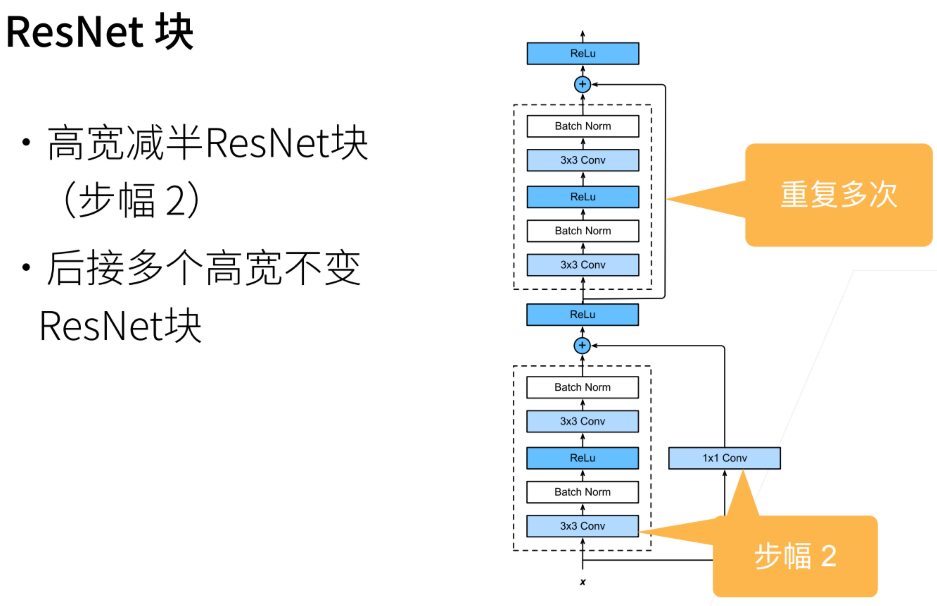

In [12]:
import torch
from torch import nn 
from torch.nn import functional as F
from d2l import torch as d2l

    
#判断是否使用1*1的卷积
class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,use_1x1conv=False, strides=1):
        super().__init__()
        #这里的stride是允许改变的
        self.conv1 = nn.Conv2d(input_channels, num_channels,kernel_size=3, padding=1, stride=strides)
        ##这里的stride默认是1，不允许改变
        self.conv2 = nn.Conv2d(num_channels, num_channels,kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        #每个bn有自己的参数要学的，不能像relu一样
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

## 输入输出形状

In [13]:
#stride=1,不使用1*1，高宽和通道数都没发生变化
#输入输出都是一样的
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [14]:
#增加输出通道数的同时，减半输出的高和宽
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## ResNet模型

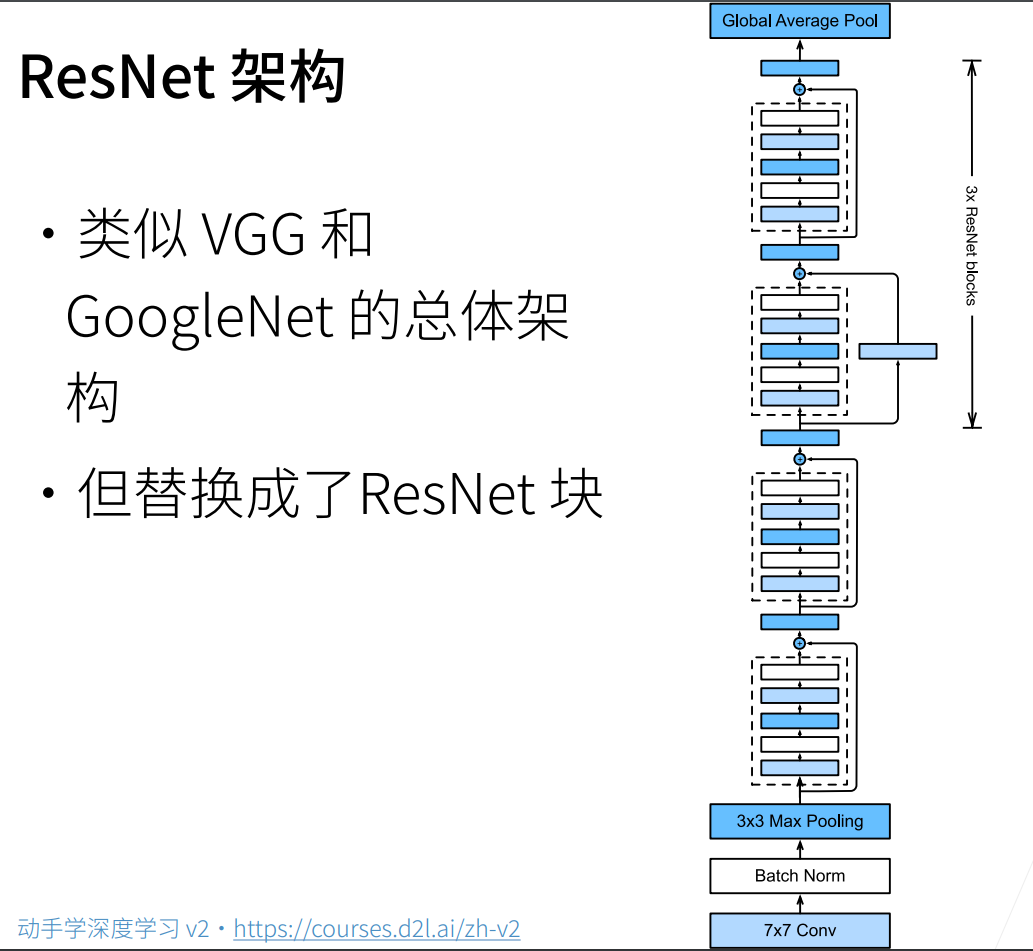

In [15]:
#一共有5个stage,每个stage中残差块的数量不等
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), 
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
#first_block=False是用来判断是否是bn2,因为bn1作的减半太多了
#b3-b5的多个残差块中只有第一个残差块改变通道数和特征图分辨率
def resnet_block(input_channels, num_channels, num_residuals,first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels, use_1x1conv=True,strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5, 
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), 
                    nn.Linear(512, 10))

In [16]:
print(net)

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

In [17]:
#观察一下ResNet中不同模块的输入形状是如何变化的
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


In [ ]:
#训练模型
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 答疑

- gbdt label上加残差
- batch size太高会导致重复性高，样本多样性降低，收敛就会出现问题
- cos学习率挺好的，比较简单，只调一个最大值和最小值
- inplace:若为false,有一个input，一个output，把input计算好之后放到output,True就是说不要output这个变量，直接在input上改写。
- 如果训练的时候加入大量的数据增强，那么测试精度是要高于训练的精度，因为测试精度没有数据增强
- 